In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras import Model, layers
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate


2025-09-18 07:21:51.622767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758180111.645159     272 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758180111.652055     272 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = '/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/'
images_path = '/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images'
masks_path = '/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks'

image_files = sorted(os.listdir(images_path))
mask_files = sorted(os.listdir(masks_path))

print('the number of images: ', len(image_files))
print('The number of masks: ', len(mask_files))

img = cv2.imread(os.path.join(images_path, image_files[0]))
mask = cv2.imread(os.path.join(masks_path, mask_files[0]), cv2.IMREAD_GRAYSCALE)
print("Image Shape: ", img.shape)
print("Mask Shape: ", mask.shape)

the number of images:  1000
The number of masks:  1000
Image Shape:  (529, 622, 3)
Mask Shape:  (529, 622)


In [3]:
#Augmentation With Albumentation
transform = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate(limit = 45, p = 0.5),
    A.ShiftScaleRotate(shift_limit = 0.1, scale_limit = 0.2, rotate_limit = 20, p = 0.5),
    A.ElasticTransform(alpha = 120, sigma = 120*0.05, alpha_affine = 120*0.03, p = 0.3),
    A.GridDistortion(p = 0.3),
    A.GaussianBlur(p = 0.2),
    A.RandomResizedCrop(size = (256, 256), scale = (0.8, 1.0), p = 0.5),
    A.RandomBrightnessContrast(p = 0.5)
])

#segmentation Data Generator with Albumentation
class AlbumentationDataGenerator(Sequence):
    def __init__(self, images_path, masks_path, image_size = (256, 256), batch_size = 8, transform = None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.transform = transform

        self.image_files = sorted(os.listdir(images_path))
        self.mask_files = sorted(os.listdir(masks_path))
        self.indexes = np.arange(len(self.image_files))

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_images, batch_masks = [], []
        
        for i in batch_indexes:
            img = cv2.imread(os.path.join(self.images_path, self.image_files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(self.masks_path, self.mask_files[i]), cv2.IMREAD_GRAYSCALE)

            if self.transform:
                augmented = self.transform(image = img, mask = mask)
                img = augmented['image']
                mask = augmented['mask']
            #REsize & Normalization
            img = cv2.resize(img, self.image_size).astype(np.float32) / 255.0
            mask = cv2.resize(mask, self.image_size).astype(np.float32) / 255.0
            batch_images.append(img)
            batch_masks.append(mask[..., np.newaxis]) #to add channel

        return np.array(batch_images), np.array(batch_masks)

batch_size = 4
image_size = (256, 256)
gen = AlbumentationDataGenerator(images_path, masks_path, batch_size = batch_size, transform = transform)
images,masks = gen[0]

print("Batch Images Shape: ", images.shape)
print("Batch Masks Shape: ", masks.shape)

Batch Images Shape:  (4, 256, 256, 3)
Batch Masks Shape:  (4, 256, 256, 1)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_272/3687516672.py:7: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha = 120, sigma = 120*0.05, alpha_affine = 120*0.03, p = 0.3),


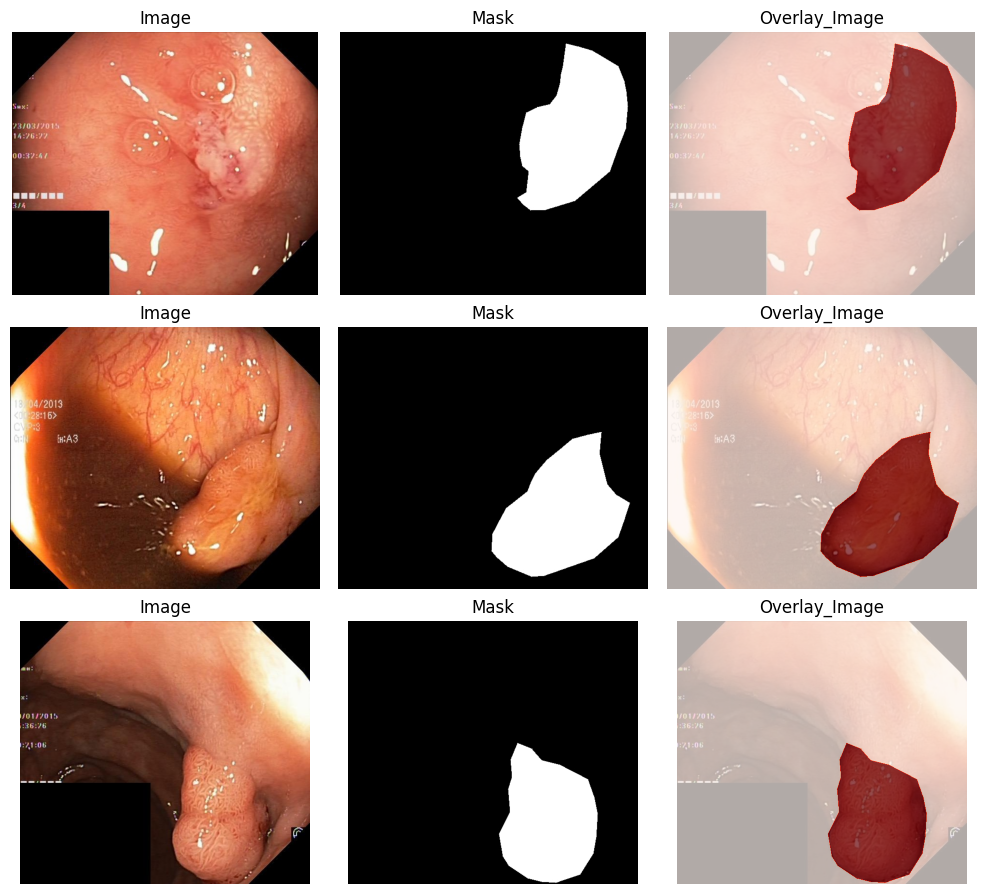

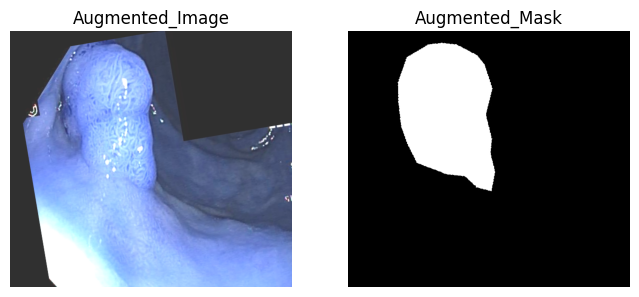

In [4]:
#Visualization
num_samples = 3
indices = np.random.randint(0, len(image_files), size = num_samples)

plt.figure(figsize = (10, num_samples*3))

for i, idx in enumerate(indices):
    img = cv2.imread(os.path.join(images_path, image_files[idx]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(masks_path, mask_files[idx]), cv2.IMREAD_GRAYSCALE)


    #Images
    plt.subplot(num_samples, 3, i*3+1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    #Mask
    plt.subplot(num_samples, 3, i*3+2)
    plt.imshow(mask, cmap = 'gray')
    plt.title("Mask")
    plt.axis('off')

    #overlay
    plt.subplot(num_samples, 3, i*3+3)
    plt.imshow(img, cmap = 'gray')
    plt.imshow(mask, cmap = 'Reds', alpha = 0.7)
    plt.title("Overlay_Image")
    plt.axis('off')

plt.tight_layout()
plt.show()


augmented = transform(image = img, mask = mask)
aug_img = augmented['image']
aug_mask = augmented['mask']

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
plt.title("Augmented_Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_mask, cmap = 'gray')
plt.title("Augmented_Mask")
plt.axis('off')
plt.show()



def simple_crop(image, mask, crop_size = 128):
    '''image--->Images
       mask--->Masks
       crop_size--->the final size of the image/mask'''
    if mask.sum() == 0:
        return image, mask

    #the coordinate of the image
    ys, xs = np.where(mask > 0)
    center_y, center_x = int(np.meam(ys), np.mask(xs))

    H, W = mask.shape
    half = crop_size // 2
    y1, y2 = max(0, center_y - half), min(H, center_y + half)
    x1, x2 = max(0, center_x - half), min(W, center_x + half)

    cropped_img = image[y1:y2, x1:x2]
    cropped_msk = mask[y1:y2, x1:x2]

    return cropped_img, cropped_msk

In [5]:
def unet_model(input_size = (256, 256, 3)):
    inputs = layers.Input(input_size)

    #Encoder
    c1 = layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    #Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p4)
    c5 = layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(c5)

    #Decoder
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4], axis = -1)
    c6 = layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3], axis = -1)
    c7 = layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2], axis = -1)
    c8 = layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(u8)
    c8 = layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1], axis = -1)
    c9 = layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(u9)
    c9 = layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(c9)

    outputs = layers.Conv2D(1, 1, activation = 'sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

model = unet_model(input_size = (256, 256, 3))
model.summary()

I0000 00:00:1758180118.300789     272 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758180118.301470     272 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 1,962,625 (7.49 MB)

 Trainable params: 1,962,625 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
train_gen = AlbumentationDataGenerator(
    images_path,
    masks_path,
    batch_size = 8,
    image_size = (256, 256),
    transform = transform  #Augmentation
)

val_gen = AlbumentationDataGenerator(
    images_path,
    masks_path,
    batch_size = 8,
    image_size = (256, 256),
    transform = None
)

In [7]:
#DICE
def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32) 
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

#IOU
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [10]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = 1- dice_coef(y_true, y_pred)
    return bce + dice

#ReduceLEOnPlateaue
lr_reducer = ReduceLROnPlateau(
    monitor = 'val_loss', #Validation_Loss
    factor = 0.5,
    patience = 3,
    min_lr = 1e-7,
    verbose = 1
)

#Compile The Model
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = 1e-4), loss = bce_dice_loss, metrics = [dice_coef, iou_coef])

#CallBacks
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
check_point = ModelCheckpoint('unet_polyp_model.h5', monitor = 'val_loss', save_best_only = True)

In [11]:
history = model.fit(train_gen, validation_data = val_gen, epochs = 35, callbacks = [early_stop, check_point, lr_reducer])

Epoch 1/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 239ms/step - dice_coef: 0.3867 - iou_coef: 0.2411 - loss: 0.9801 - val_dice_coef: 0.4522 - val_iou_coef: 0.2946 - val_loss: 0.8969 - learning_rate: 1.0000e-04
Epoch 2/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 230ms/step - dice_coef: 0.4275 - iou_coef: 0.2749 - loss: 0.9202 - val_dice_coef: 0.4572 - val_iou_coef: 0.2987 - val_loss: 0.8633 - learning_rate: 1.0000e-04
Epoch 3/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - dice_coef: 0.4441 - iou_coef: 0.2880 - loss: 0.9020 - val_dice_coef: 0.4052 - val_iou_coef: 0.2556 - val_loss: 0.8995 - learning_rate: 1.0000e-04
Epoch 4/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - dice_coef: 0.4504 - iou_coef: 0.2940 - loss: 0.8895 - val_dice_coef: 0.4504 - val_iou_coef: 0.2932 - val_loss: 0.8613 - learning_rate: 1.0000e-04
Epoch 5/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - dice_coef: 0.4655 - iou_coef: 0.3063 - loss: 0.8686 - val_dice_coef: 0.4768 - val_iou_coef: 0.3158 - val_loss: 0.8649 - learning_ra

In [12]:
test_result = model.evaluate(val_gen)
print("Test_Loss: ", test_result[0])
print("Dice_Coef: ", test_result[1])
print("IOU: ", test_result[2])

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - dice_coef: 0.6971 - iou_coef: 0.5394 - loss: 0.5034
Test_Loss:  0.4914746880531311
Dice_Coef:  0.7089186906814575
IOU:  0.55408775806427


In [13]:
val_batch_images, val_batch_masks = next(iter(val_gen))
y_pred = model.predict(val_batch_images)
y_true = val_batch_masks.flatten().astype(np.uint8)
y_pred = (y_pred.flatten() > 0.5).astype(np.uint8) #Threshold

confus_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names = ["Background", "Polyp"])

print("Confusion_Matrix: \n", confus_matrix)
print("Classification_Report: \n", class_report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion_Matrix: 
 [[409553  24795]
 [ 23302  66638]]
Classification_Report: 
               precision    recall  f1-score   support

  Background       0.95      0.94      0.94    434348
       Polyp       0.73      0.74      0.73     89940

    accuracy                           0.91    524288
   macro avg       0.84      0.84      0.84    524288
weighted avg       0.91      0.91      0.91    524288



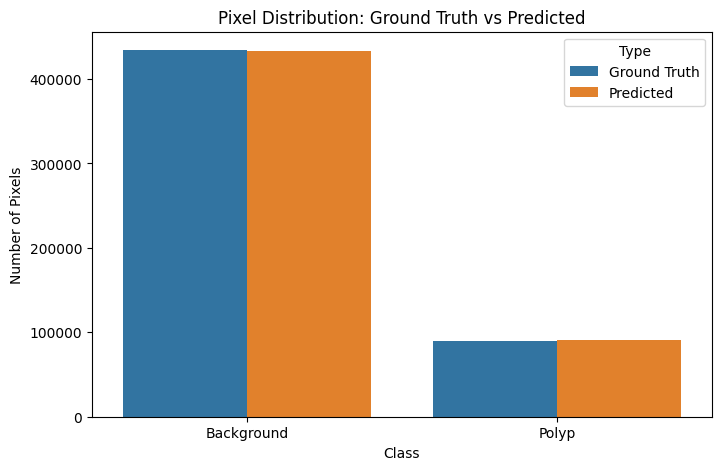

In [14]:
classes = ["Background", "Polyp"]
true_counts = [sum(y_true == 0), sum(y_true == 1)]
pred_counts = [sum(y_pred == 0), sum(y_pred == 1)]

df = pd.DataFrame({
    "Class": classes*2,
    "Pixel Count": true_counts + pred_counts,
    "Type": ["Ground Truth"]*2 + ["Predicted"]*2
})

plt.figure(figsize=(8,5))
sns.barplot(x="Class", y="Pixel Count", hue="Type", data=df)
plt.title("Pixel Distribution: Ground Truth vs Predicted")
plt.ylabel("Number of Pixels")
plt.show()

In [24]:
##### Training the Model with Class Wieght

#Class_Weight

#We have taken a batch from validation_generator(val_gen)
val_batch_images, val_batch_masks = next(iter(val_gen))

y_true = val_batch_masks.flatten() #transform it to 1D array

#Number of pixels for each class(Background & Polyp)
num_background = np.sum(y_true == 0)
num_polyp = np.sum(y_true == 1)
total_pixels = len(y_true)

#Calculate the weight for each class(Background & Polyp)
weight_background = total_pixels / (2 * num_background)
weight_polyp = total_pixels / (2 * num_polyp)

class_weights = {0: weight_background, 1: weight_polyp}
print("Class_Weight: ", class_weights)



#Merge the Class_Weight with Loss_Function
def weight_bce(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    weight = y_true_f * class_weights[1] + (1 - y_true_f) * class_weights[0]
    bce = tf.keras.backend.binary_crossentropy(y_true_f, y_pred_f)

    weight_bce = weight * bce
    return tf.keras.backend.mean(weight_bce)

def bce_dice_loss(y_true, y_pred):
    dice = 1 - dice_coef(y_true, y_pred)
    return weight_bce(y_true, y_pred) + dice

Class_Weight:  {0: 0.6133673385823087, 1: 2.9146542139203913}


In [25]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
             loss = bce_dice_loss,
             metrics = [dice_coef, iou_coef])

In [26]:
history = model.fit(train_gen, validation_data = val_gen, epochs = 30,
                    callbacks = [early_stop, lr_reducer, check_point])

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - dice_coef: 0.7033 - iou_coef: 0.5482 - loss: 0.5841 - val_dice_coef: 0.7496 - val_iou_coef: 0.6039 - val_loss: 0.5139 - learning_rate: 1.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - dice_coef: 0.7170 - iou_coef: 0.5650 - loss: 0.5613 - val_dice_coef: 0.7178 - val_iou_coef: 0.5650 - val_loss: 0.5176 - learning_rate: 1.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - dice_coef: 0.6834 - iou_coef: 0.5254 - loss: 0.6126 - val_dice_coef: 0.7512 - val_iou_coef: 0.6063 - val_loss: 0.5219 - learning_rate: 1.0000e-04
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - dice_coef: 0.7057 - iou_coef: 0.5517 - loss: 0.5757 - val_dice_coef: 0.7497 - val_iou_coef: 0.6046 - val_loss: 0.4898 - learning_rate: 1.0000e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - dice_coef: 0.7026 - iou_coef: 0.5481 - loss: 0.5708 - val_dice_coef: 0.7464 - val_iou_coef: 0.6000 - val_loss: 0.5123 - learning_ra

In [27]:
test_result = model.evaluate(val_gen)
print("Test_Loss: ", test_result[0])
print("Dice_Coef: ", test_result[1])
print("IOU: ", test_result[2])

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - dice_coef: 0.7818 - iou_coef: 0.6466 - loss: 0.4110
Test_Loss:  0.39770352840423584
Dice_Coef:  0.7943360805511475
IOU:  0.6632680296897888


In [37]:
#Prediction
val_batch_images, val_batch_masks = next(iter(val_gen))
y_pred = model.predict(val_batch_images)
y_pred_thresh = (y_pred > 0.5).astype(np.uint8) #to be binary

y_true_flat = val_batch_masks.flatten().astype(np.uint8)
y_pred_flat = y_pred_thresh.flatten()

confus_matrix = confusion_matrix(y_true_flat, y_pred_flat)
class_report = classification_report(y_true_flat, y_pred_flat, target_names = ['Background', 'Polyp'])
print("Confusion_Matrxi: \n", confus_matrix)
print("Classification_Report: \n", class_report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Confusion_Matrxi: 
 [[394112  40236]
 [  6292  83648]]
Classification_Report: 
               precision    recall  f1-score   support

  Background       0.98      0.91      0.94    434348
       Polyp       0.68      0.93      0.78     89940

    accuracy                           0.91    524288
   macro avg       0.83      0.92      0.86    524288
weighted avg       0.93      0.91      0.92    524288



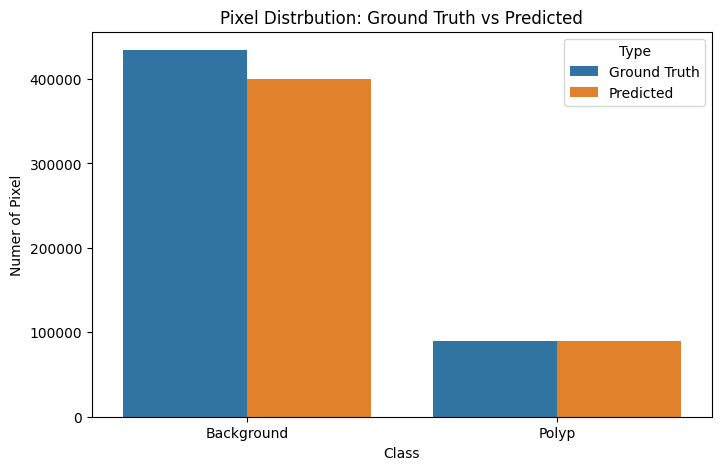

In [41]:
classes = ["Background", "Polyp"]
true_counts = [np.sum(y_true_flat == 0), np.sum(y_true_flat == 1)]
pred_counts = [np.sum(y_pred_flat == 0), np.sum(y_true_flat == 1)]

df = pd.DataFrame({
    "Class": classes * 2,
    "Pixel Count": true_counts + pred_counts,
    "Type": ['Ground Truth'] * 2 + ["Predicted"] * 2
})

plt.figure(figsize = (8, 5))
sns.barplot(x = "Class", y = "Pixel Count", hue = "Type", data = df)
plt.title("Pixel Distrbution: Ground Truth vs Predicted")
plt.ylabel("Numer of Pixel")
plt.show()

In [47]:
model.save("/kaggle/working/unet_polyp_model.h5")

In [46]:
from tensorflow.keras.models import load_model
model = load_model('/kaggle/working/unet_polyp_model.h5', custom_objects = {
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
    })